In [1]:
import numpy as np

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.animation import FuncAnimation

from scipy.misc import derivative
from scipy.integrate import quad

from pynverse import inversefunc

import seaborn as sns

<IPython.core.display.Javascript object>


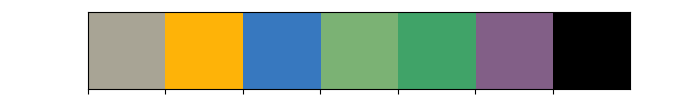

In [2]:
custom_palette = [ "greyish", "amber", "windows blue", "faded green", "greenish", 
                    "dusty purple","black" ] #"green blue", "dull green", "faded green",  
sns.set_palette(sns.xkcd_palette(custom_palette))
current_palette = sns.color_palette()

#%matplotlib inline
%matplotlib notebook

sns.palplot(current_palette)

# -------------------------------------------------------------------------------------
# Class and Optimal Allocations
# -------------------------------------------------------------------------------------

In [2]:
class system(object):
    def __init__(self, n, r, mus, phis, etas, thetas, fs, gammas, dec = True,
                 T = 10, dt = 1e-4, tol = 1e-8, verbose = False, seed = 0):
                
        # Need to catch mistakes in dimension initiating this
        # Need to check that params are OK (e.g. phi_i eta_i < 1, all are non-neg)
        
        # Fundamental Parameters
        self.n = n
        self.r = r
        self.mus = mus
        self.phis = phis
        self.etas = etas
        
        
        # Shock Arrival Rate
        self.thetas = thetas   # not yet accounting for mutually exciting things...?
        
        
        # Distributions of Liq. Shocks
        self.fs = fs     # Densities
        self.Fs = [lambda x: quad(f, 0, x)[0] for f in fs]

        self.fs_inv = [inversefunc(f) for f in fs]

        
        # Risk Aversion
        self.gammas = gammas
        self.Gs = [(lambda x, gamma = gamma: -np.log(1 - x)) if (gamma == 1) 
                   else (lambda x, gamma = gamma: (1 - (1-x)**(1-gamma))/(1-gamma)) 
                   for gamma in gammas]
        
        
        # Decentralized?
        self.dec = dec
                
                
        # Simulation Params
        self.T = T
        self.dt = dt
        
        self.n_iter = int(T/dt)
        self.ts = np.linspace(dt,T, int(self.n_iter))
        
        self.iter = 0
        self.t = 0
        
        
        # Seeding
        np.random.seed(seed)
        self.rand = np.random.uniform(size = (self.n_iter, n))
        
                
        # Technical Params.
        self.tol = tol           # tolerance for alternating minimization of cent. opt.
        self.verbose = verbose
    
                
        # State Variables
        self.S = np.ones((self.n_iter, n))      # prices (not needed..., not implemented...)
        self.N = np.zeros((self.n_iter, n))     # jump processes
        self.X = np.zeros((self.n_iter, n))     # wealth
        self.C = np.zeros((self.n_iter, n))     # cash held (fraction of wealth)
        self.W = np.zeros((self.n_iter, n, n))  # assets held (fraction of wealth)
        
        
        # Initialize Wealth to start at 1
        self.X[0,:] = 1
        
        return
        
        
    
    def step(self):
    
        k = self.iter
        
        # Update Portfolios 
        if self.dec:
            (C, W) = self.opt_dec()
        else:
            (C, W) = self.opt_cent()
           
            
        # Determine Jumps
        N = [int( (self.rand[k,i]) < (self.dt*self.thetas[i]*(1-self.Fs[i](C[i]))) ) 
             for i in range(self.n)]
        
        
        # Update Wealth
        X = [self.X[k,i]*(1 + self.dt*((1-C[i])*r + W[i,:] @ self.mus) - W[i,:] @ np.diag(self.phis) @ N - self.etas[i]*N[i]) 
             for i in range(self.n)]

        
        # Update State Vars
        self.N[k,:] = N
        self.C[k,:] = C
        self.W[k,:,:] = W
        self.X[k+1,:] = X

        
        # Update Time
        self.iter = self.iter + 1
        self.t = self.t + self.dt
        return
    
    

    
    
    def opt_dec(self):
        
        # Solve for c_i's
        C = [self.fs_inv[i]((self.r)/(self.thetas[i]*self.Gs[i](self.etas[i]))) 
             if (self.r)/(self.thetas[i]*self.Gs[i](self.etas[i])) <= self.fs[i](0) 
             else 0 
             for i in range(self.n)]
            
        # Solve for w_ij's
        W = np.zeros((self.n,self.n))
        for i in range(self.n):
            W[i,:] = [(1/self.phis[j])*max(0, 1-((self.phis[j]*self.thetas[j]*(1 - self.Fs[j](C[j])))/(self.mus[j]))**(1/self.gammas[i]) ) 
                      if j!= i 
                      else 0 
                      for j in range(self.n)]     
        

        if self.verbose:
            #print([self.fs[i](C[i]) for i in range(self.n)])
            print(C)
            print(W)
        
    
        return (np.array(C), W)
    
    
    def opt_cent(self):
        
        if not (np.array(gammas) == 1).all():
            raise Exception('Must have exclusively gamma = 1 (i.e. Logarithmic Utility Functions)') 
            
        
        # Check conditions for uniqueness of centralized optimum.
        for i in range(self.n):
            c_tilde = inversefunc(self.Fs[i])(max(1 - self.mus[i]/(self.thetas[i]*self.phis[i]), 0))
            
            if c_tilde == 0:
                cond_2nd_deriv = -np.log(1-self.etas[i]) - (self.n-1)*(np.log((self.phis[i]*self.thetas[i])/(self.mus[i])) - (self.fs[i](0)**2)/(derivative(self.fs[i], 0, dx = 1e-3)))
                cond_1st_deriv = -np.log(1-self.etas[i]) - self.r/(self.thetas[i]*self.fs[i](0)) - (self.n-1)*np.log((self.phis[i]*self.thetas[i])/(self.mus[i]))
            else:
                cond_2nd_deriv = -np.log(1-self.etas[i]) + (self.n-1)*(self.phis[i]*self.thetas[i]*self.fs[i](c_tilde)**2)/(self.mus[i]*derivative(self.fs[i], c_tilde, dx = 1e-3))
                cond_1st_deriv = -np.log(1-self.etas[i]) - self.r/(self.thetas[i]*self.fs[i](c_tilde))
                
            if not ((cond_2nd_deriv > 0) or (cond_1st_deriv > 0)):
                print(i)
                print(cond_1st_deriv)
                print(cond_2nd_deriv)
                raise Exception('ValueError: Uniqueness not guaranteed for i='+str(i))
        
        
        
        # Initialize
        C = np.zeros(self.n) ## Starting at Zeros (vs. ones) may give a different solution! Uniqueness is guaranteed by the upper bound on r...
        W = np.zeros(self.n) ## All investment amounts will be the same (since every firm has logarithmic utility)
        
        
        # Iterate to Convergence
        count = 0
        while True:
            #print(count)
            count = count+1
            
            W_old = W.copy()
            C_old = C.copy()
             
            # Update W's
            W = [(1/self.phis[j])*max(0, 1-(self.phis[j]*self.thetas[j]*(1 - self.Fs[j](C[j])))/(self.mus[j]) ) 
                 for j in range(self.n)]
            
            # Update C's
            C = [self.fs_inv[i]((self.r)/(self.thetas[i]*(self.Gs[i](self.etas[i]) + (self.n - 1)*self.Gs[i](self.phis[i]*W[i]) ))) 
                 if (self.r)/(self.thetas[i]*(self.Gs[i](self.etas[i]) + (self.n - 1)*self.Gs[i](self.phis[i]*W[i]) )) <= self.fs[i](0) 
                 else 0 
                 for i in range(self.n)]
        
        
            if sum(np.abs(np.array(W_old) - np.array(W))) < self.tol:
                break
        

        
        if self.verbose:
            #print([self.fs[i](C[i]) for i in range(self.n)])
            print(C)
            print(W)
        
        return (np.array(C), (np.ones((self.n, self.n)) - np.identity(self.n) ) @ np.diag(W))
    
    
        
    
        

# -------------------------------------------------------------------------------------
# Simulation: Sec. 4.1 -- Comparing Trajectories
# -------------------------------------------------------------------------------------

In [24]:
n = 3

r = 0.03
mus = [0.015,0.02,0.03]
phis = [0.2,0.3,0.5]
etas = [0.5,0.6,0.7]

thetas = [0.04, 0.08, 0.12]

lambdas = [0.5, 0.6, 0.7]
fs = [lambda x, l = l: l*np.exp(-l*x) for l in lambdas]

gammas = [1, 1, 1]

T = 50
dt = 0.1

<IPython.core.display.Javascript object>


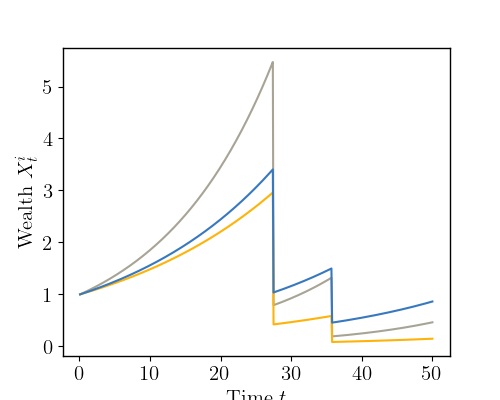

In [25]:
sys = system(n, r, mus, phis, etas, thetas, fs, gammas, dec = False,
                 T = T, dt = dt, tol = 1e-8, verbose = False, seed = 0)

while sys.t < T-dt:
    sys.step()


plt.rcParams.update({'font.size': 15, 'axes.linewidth': 1 ,
                     'text.usetex':  True, "font.family": "Computer Modern",})
f, ax = plt.subplots(figsize = (5,4))

plt.plot(sys.ts, sys.X)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Wealth $X^i_t$')
#ax.set_yscale('log')
plt.savefig('./Fig/Wealth_Ex_Cent.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


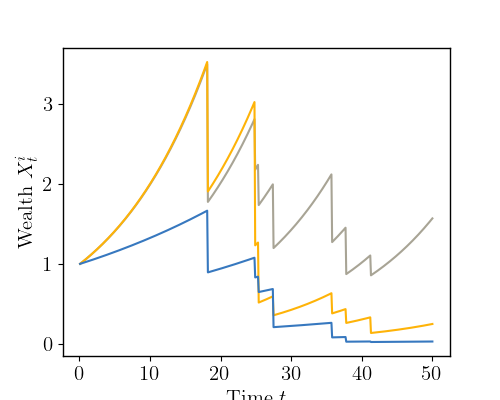

In [26]:
sys = system(n, r, mus, phis, etas, thetas, fs, gammas, dec = True,
                 T = T, dt = dt, tol = 1e-8, verbose = False, seed = 0)

while sys.t < T-dt:
    sys.step()


plt.rcParams.update({'font.size': 15, 'axes.linewidth': 1 ,
                     'text.usetex':  True, "font.family": "Computer Modern",})
f, ax = plt.subplots(figsize = (5,4))

plt.plot(sys.ts, sys.X)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Wealth $X^i_t$')
#ax.set_yscale('log')
plt.show()
plt.savefig('./Fig/Wealth_Ex_Dec.pdf',bbox_inches='tight')

# -------------------------------------------------------------------------------------
# Simulation: Network Images and Dynamics
# -------------------------------------------------------------------------------------

In [9]:
n = 3

r = 0.03
mus = [0.015,0.02,0.03]
phis = [0.2,0.3,0.5]
etas = [0.5,0.6,0.7]

thetas = [0.04, 0.08, 0.12]

lambdas = [0.5, 0.6, 0.7]
fs = [lambda x, l = l: l*np.exp(-l*x) for l in lambdas]

gammas = [0.5, 1.7, 1]

dec = True

T = 50
dt = 0.1

In [10]:
sys = system(n, r, mus, phis, etas, thetas, fs, gammas, dec = dec,
                 T = T, dt = dt, tol = 1e-8, verbose = False, seed = 0)

while sys.t < T-dt:
    sys.step()

<IPython.core.display.Javascript object>


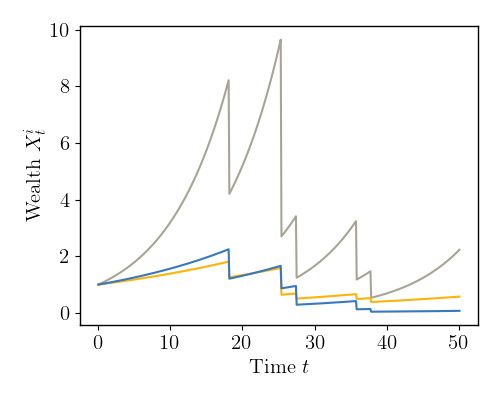

In [11]:
plt.rcParams.update({'font.size': 15, 'axes.linewidth': 1 ,
                     'text.usetex':  True, "font.family": "Computer Modern",})
f, ax = plt.subplots(figsize = (5,4))

plt.plot(sys.ts, sys.X)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Wealth $X^i_t$')
#ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [12]:
r = 0.05
mus = [0.009, 0.01, 0.015, 0.013, 0.013]
phis = [0.2, 0.3, 0.9, 0.6, 0.82]
etas = [0.5, 0.6, 0.7, 0.4, 0.9]

thetas = [0.04, 0.08, 0.12, 0.05, 0.02]

lambdas = [0.5, 0.6, 0.7, 2, 2.4]
fs = [lambda x, l = l: l*np.exp(-l*x) for l in lambdas]

gammas = [0.5, 1.7, 1, 0.3, 0.87]

n = len(mus)

dec = True

T = 50
dt = 0.1

In [13]:
sys = system(n, r, mus, phis, etas, thetas, fs, gammas, dec = dec,
                 T = T, dt = dt, tol = 1e-8, verbose = False, seed = 0)

while sys.t < T-dt:
    sys.step()

<IPython.core.display.Javascript object>


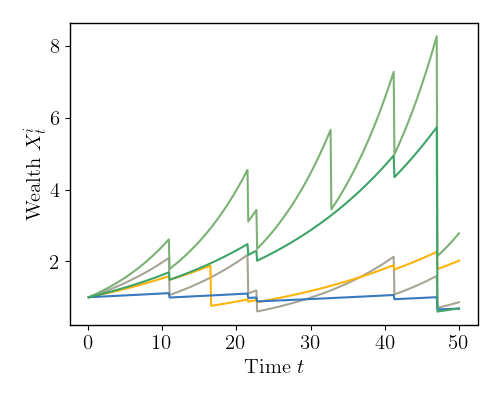

In [14]:
plt.rcParams.update({'font.size': 15, 'axes.linewidth': 1 ,
                     'text.usetex':  True, "font.family": "Computer Modern",})
f, ax = plt.subplots(figsize = (5,4))

plt.plot(sys.ts, sys.X)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Wealth $X^i_t$')
#ax.set_yscale('log')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


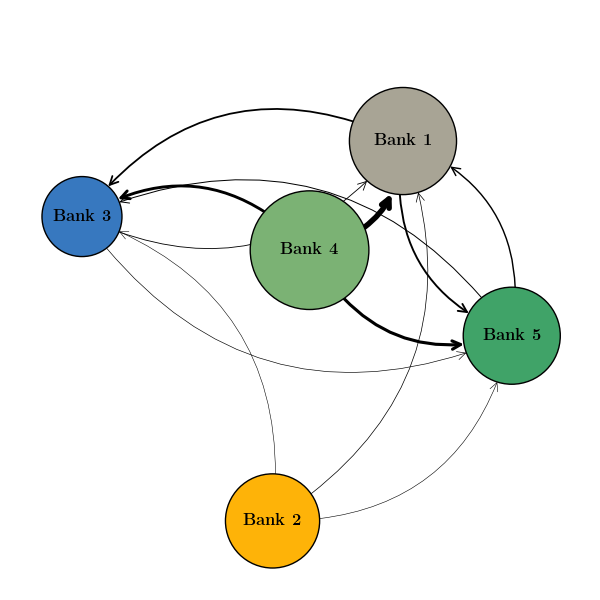

In [15]:
t = 100
frames = 1 #sys.X.shape[0]-1
ax_scale = 1.05
nodesize_scale = 3000
edgewidth_scale = 1
pos_scale = 200

fig, ax = plt.subplots(figsize = (6,6))
ax.axis('off')

wealths = sys.X[t,:]
investments = np.diag(wealths) @ sys.W[t,:,:] 

G = nx.from_numpy_matrix(investments, create_using = nx.DiGraph)
widths = nx.get_edge_attributes(G, 'weight')


pos = nx.spring_layout(G, seed = 0)
pos.update((key, value * pos_scale) for key, value in pos.items())

nx.draw_networkx_nodes(G, pos = pos, ax = ax, node_size = nodesize_scale*wealths,
                       node_color = current_palette[0:n], edgecolors = 'black')
nx.draw_networkx_labels(G, pos = pos, ax = ax,  labels = {i:str(r'$\textbf{Bank }$'+r'$\mathbf{'+str(i+1)+'}$') for i in pos.keys()},
                        font_color = 'black', font_weight = 'bold')
nx.draw_networkx_edges(G, pos = pos, ax = ax, edgelist = list(widths.keys()), width = np.array(list(widths.values()))*edgewidth_scale,
                       connectionstyle='arc3,rad=0.4', edge_color = 'black',
                       arrowsize = 15, arrowstyle = '->',
                       node_size = nodesize_scale*wealths)

ax.set_xlim([item*ax_scale for item in ax.get_xlim()])
ax.set_ylim([item*ax_scale for item in ax.get_ylim()])

plt.tight_layout()
plt.savefig('./Fig/SRisk_Network.pdf')

<IPython.core.display.Javascript object>


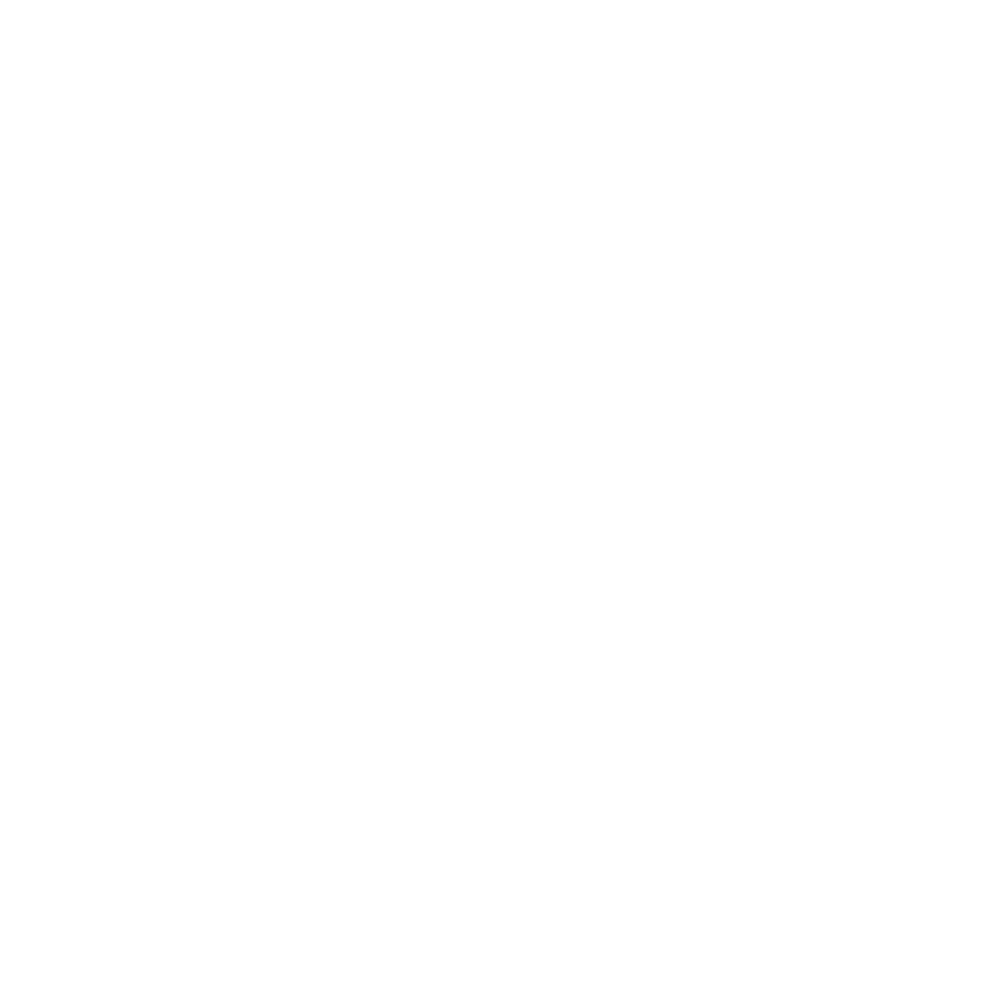

In [16]:
t0 = 100
frames = 1 #sys.X.shape[0]-1
ax_scale = 1.5
nodesize_scale = 3000
edgewidth_scale = 1
pos_scale = 200

fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')

def update(t):
    ax.clear()
    ax.axis('off')
    
    wealths = sys.X[t0+t,:]
    investments = np.diag(wealths) @ sys.W[t0+t,:,:] 

    G = nx.from_numpy_matrix(investments, create_using = nx.DiGraph)
    widths = nx.get_edge_attributes(G, 'weight')
    
    if t > t0:
        prev_pos = nx.spring_layout(nx.from_numpy_matrix(sys.W[0,:,:], create_using = nx.DiGraph), seed = 0)
        pos = nx.spring_layout(G, pos = prev_pos, seed = 0, iterations = 1, k = 1)

    else:
        pos = nx.spring_layout(G, seed = 0)
    pos.update((key, value * pos_scale) for key, value in pos.items())
    
    nx.draw_networkx_nodes(G, pos = pos, ax = ax, node_size = nodesize_scale*wealths,
                           node_color = current_palette[0:n], edgecolors = 'black')
    nx.draw_networkx_labels(G, pos = pos, ax = ax,  labels = {i:str(r'$\textbf{Bank }$'+r'$\mathbf{'+str(i+1)+'}$') for i in pos.keys()},
                            font_color = 'black', font_weight = 'bold')
    nx.draw_networkx_edges(G, pos = pos, ax = ax, edgelist = list(widths.keys()), width = np.array(list(widths.values()))*edgewidth_scale,
                           connectionstyle='arc3,rad=0.4', edge_color = 'black',
                           arrowsize = 15, arrowstyle = '->',
                           node_size = nodesize_scale*wealths)

    ax.set_xlim([item*ax_scale for item in ax.get_xlim()])
    ax.set_ylim([item*ax_scale for item in ax.get_ylim()])


ani = FuncAnimation(fig, update, frames=frames, interval=1, repeat=False)
plt.show()

<IPython.core.display.Javascript object>


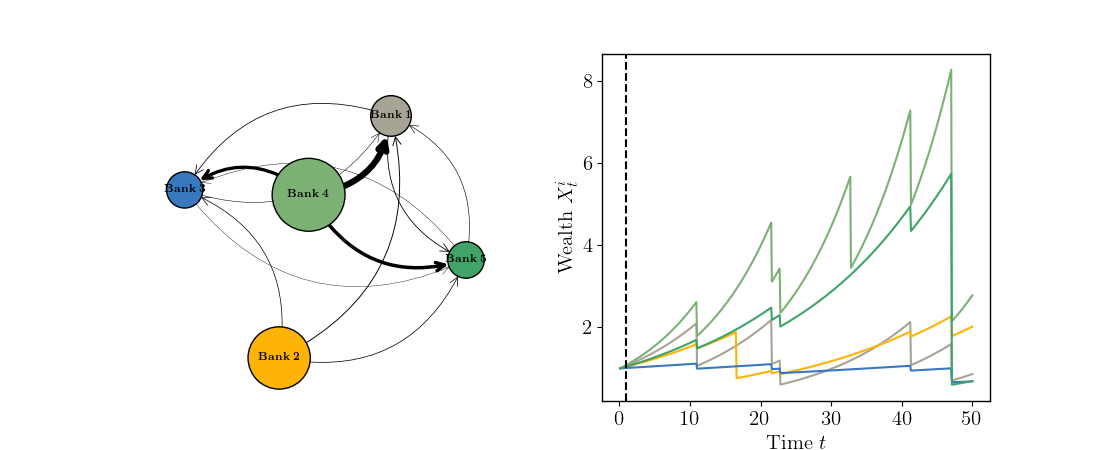

C:\Users\DanielRigobon\miniconda3\envs\sys_risk\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [17]:
frames = sys.X.shape[0]-1
ax_scale = 1.1
nodesize_scale = 1000
edgewidth_scale = 1
pos_scale = 1

fig, ax = plt.subplots(1, 2, figsize = (11,4.5))
ax[0].axis('off')


ax[1].plot(sys.ts, sys.X)
ax[1].set_xlabel('Time $t$')
ax[1].set_ylabel('Wealth $X^i_t$')
#ax[1].set_yscale('log')

line = ax[1].axvline(x = 0.5, linestyle = '--', linewidth = 1.5, color = 'black')

def update(t):
    
    line.set_data(([sys.ts[t],sys.ts[t]],[0,1]))
    
    ax[0].clear()
    ax[0].axis('off')
    
    wealths = sys.X[t,:]
    investments = np.diag(wealths) @ sys.W[t,:,:] 

    G = nx.from_numpy_matrix(investments, create_using = nx.DiGraph)
    widths = nx.get_edge_attributes(G, 'weight')
    
    if t > 0:
        prev_pos = nx.spring_layout(nx.from_numpy_matrix(sys.W[0,:,:], create_using = nx.DiGraph), seed = 0)
        pos = nx.spring_layout(G, pos = prev_pos, seed = 0, iterations = 1, k = 10)

    else:
        pos = nx.spring_layout(G, seed = 0)
    pos.update((key, value * pos_scale) for key, value in pos.items())
    
    nx.draw_networkx_nodes(G, pos = pos, ax = ax[0], node_size = nodesize_scale*wealths,
                           node_color = current_palette[0:n], edgecolors = 'black')
    nx.draw_networkx_labels(G, pos = pos, ax = ax[0],  labels = {i:str(r'$\textbf{Bank }$'+r'$\mathbf{'+str(i+1)+'}$') for i in pos.keys()},
                            font_color = 'black', font_size = 8)
    nx.draw_networkx_edges(G, pos = pos, ax = ax[0], edgelist = list(widths.keys()), width = np.array(list(widths.values()))*edgewidth_scale,
                           connectionstyle='arc3,rad=0.4', edge_color = 'black',
                           arrowsize = 15, arrowstyle = '->',
                           node_size = nodesize_scale*wealths)

    ax[0].set_xlim([item*ax_scale for item in ax[0].get_xlim()])
    ax[0].set_ylim([item*ax_scale for item in ax[0].get_ylim()])


ani = FuncAnimation(fig, update, frames=frames, interval=1, repeat=False)
plt.show()

In [18]:
gif_path = './Fig/Network_Ani_w_Wealth.gif'
ani.save(gif_path, writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.


# -------------------------------------------------------------------------------------
# Simulation: Sec. 4.3 -- Price of Anarchy
# -------------------------------------------------------------------------------------

In [19]:
n_max = 200

r = 0.01
mus = [0.045]
phis = [0.4]
etas = [0.5]

thetas = [0.1]

lambdas = [1]
fs = [lambda x: l*np.exp(-l*x) for l in lambdas]

gammas = [1]

T = 100
dt = 1

PoAs = list()

In [21]:
for n in range(2, n_max + 1):
    
    print('-----------------\nn = '+str(n))

    sys = system(n, r, mus*n, phis*n, etas*n, thetas*n, fs*n, gammas*n,
                 T = T, dt = dt, tol = 1e-8, verbose = False, seed = 0)

    (C,W) = sys.opt_dec()
    dec_val =  sys.n*((sys.T)*(sys.r*(1 - C[0]) + (sys.n-1)*W[0,1]*sys.mus[0] - 
                               sys.thetas[0]*(1-sys.Fs[0](C[0]))*(-np.log(1-sys.etas[0])-(sys.n-1)*np.log(1-sys.phis[0]*W[0,1]))) 
                      + np.log(sys.X[0,0])
                      )
    
    
    
    (C,W) = sys.opt_cent()
    cent_val =  sys.n*((sys.T)*(sys.r*(1 - C[0]) + (sys.n-1)*W[0,1]*sys.mus[0] - 
                                sys.thetas[0]*(1-sys.Fs[0](C[0]))*(-np.log(1-sys.etas[0])-(sys.n-1)*np.log(1-sys.phis[0]*W[0,1]))) 
                       + np.log(sys.X[0,0])
                       )
    
    PoAs.append(cent_val/dec_val)
    print(cent_val/dec_val)
    

-----------------
n = 2
1.466014167469267
-----------------
n = 3
1.5044669567658335
-----------------
n = 4
1.5309533447062365
-----------------
n = 5
1.5483648579996128
-----------------
n = 6
1.5606684819205687
-----------------
n = 7
1.569863490300394
-----------------
n = 8
1.577025183941746
-----------------
n = 9
1.5827802692150972
-----------------
n = 10
1.5875189831872056
-----------------
n = 11
1.591497505537991
-----------------
n = 12
1.5948913326410896
-----------------
n = 13
1.5978249601281143
-----------------
n = 14
1.6003893082780236
-----------------
n = 15
1.6026524264700865
-----------------
n = 16
1.6046663263369325
-----------------
n = 17
1.6064714893472194
-----------------
n = 18
1.6080999259265834
-----------------
n = 19
1.609577303630826
-----------------
n = 20
1.6109244602939938
-----------------
n = 21
1.6121585008731631
-----------------
n = 22
1.6132936063504497
-----------------
n = 23
1.6143416395883348
-----------------
n = 24
1.6153126054919686
-

1.6384176405088635
-----------------
n = 188
1.6384414393232556
-----------------
n = 189
1.6384650093034143
-----------------
n = 190
1.6384883538246175
-----------------
n = 191
1.6385114761951205
-----------------
n = 192
1.638534379657833
-----------------
n = 193
1.6385570673919543
-----------------
n = 194
1.6385795425145149
-----------------
n = 195
1.638601808081921
-----------------
n = 196
1.6386238670914355
-----------------
n = 197
1.6386457224826163
-----------------
n = 198
1.6386673771386964
-----------------
n = 199
1.6386888338879477
-----------------
n = 200
1.6387100955050053


In [22]:
(C,W) = sys.opt_dec()

lim = (sys.mus[0]/sys.phis[0])/(sys.mus[0]*W[0,1] + sys.thetas[0]*(1 - sys.Fs[0](C[0]))*np.log(1 - sys.phis[0]*W[0,1]))

<IPython.core.display.Javascript object>


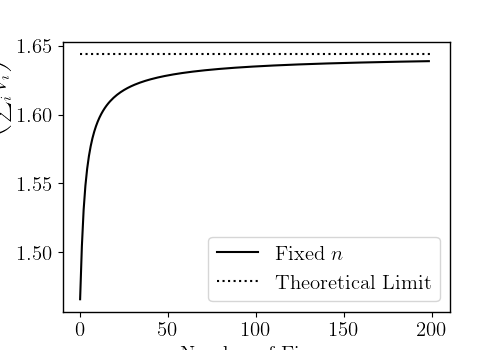

In [23]:
plt.rcParams.update({'font.size': 15, 'axes.linewidth': 1 ,
                     'text.usetex':  True, "font.family": "Computer Modern",})
f, ax = plt.subplots(figsize = (5,3.5))

plt.plot(PoAs, 'k-', label = 'Fixed $n$')
plt.hlines(lim, 0, 200, linestyle = ':', color = 'k', label = 'Theoretical Limit')
plt.xlabel('Number of Firms')
plt.ylabel(r'Price of Anarchy $\displaystyle\left(\frac{V}{\sum_i V_i}\right)$')
plt.legend()
plt.savefig('./Fig/PoA_Simulation.pdf',bbox_inches='tight')